In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import random 
import datetime as dt
import re
import pickle
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation

from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ml_task_1/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [ ]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Text(0.5, 1.0, 'Ratio of missing values per columns')

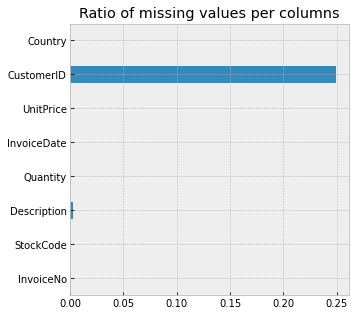

In [ ]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [ ]:
nan_rows = data[data.isnull().T.any().T]
nan_rows.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


Since the missing values are only in the CustomerID column and the description column, we could try to look at the InvoiceNo and see if maybe we can find the Customer ID

In [ ]:
data[data['InvoiceNo']== '536414']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom


In [ ]:
data[data['InvoiceNo']== '536544'][:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom


It appears that we can't replace the missing values and we can't keep data without the value in the customer id columns since we want to classify the customers. So I'll drop the lines with missing values on the customer ID column.

In [ ]:
data = data.dropna(subset=["CustomerID"])

Text(0.5, 1.0, 'Ratio of missing values per columns')

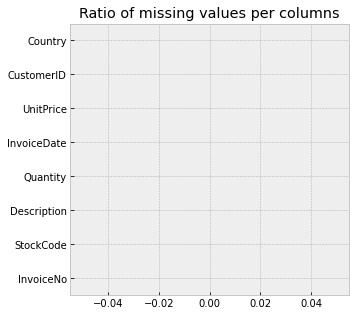

In [ ]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

There are no more missing values. I'll now check the dupplicate values and drop them if there's any.

In [ ]:
print('Dupplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Dupplicate entries: 5225


**EDA**

In [ ]:
data.Country.nunique()

37

In [ ]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)


,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


More than 90% of the data is coming from UK !

**Quantity**

In [ ]:
data.describe()

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [ ]:
data[(data['Quantity']<0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


The stock code values aren't only numerical, there are speciales values like D which means Discount

The InvoiceNo aren't also only numerical since there is a C before the other numbers for every negative value in the quantity column, this could mean that the order was canceled.

**InvoiceNo - Cancelation Code**

There are negative quanity in significant amount, arount 12.5, we need some domain knowldge for understanding this negative quantity, but for now , I m discarding it.

In [ ]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [ ]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

It appears that more than 16% of the transactions were canceled which is significant. Let's take a look at some rows where the transaction was canceled.

In [ ]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1][:5]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [ ]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom


it appears that there is a counterpart to the canceled transaction in the database. Let's see if this is always the case.

In [ ]:
test = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        print('Our initial hypothesis is wrong')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
Our initial hypothesis is wrong


In [ ]:
a = ['India','pak','bangladesh','china','spain','Portugal']
b = [1,2,3,4,5,6]
dict(zip(a,b))

{'India': 1, 'pak': 2, 'bangladesh': 3, 'china': 4, 'spain': 5, 'Portugal': 6}

In [ ]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,12/5/2010 13:17,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/5/2010 13:17,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,12/5/2010 13:17,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,12/5/2010 13:17,3.95,14527,United Kingdom


It appears that when there is a discount there are no counterparts. Let's try again but without the discount values

In [ ]:
data_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, data_check.loc[index])
        print('The second hypothesis is also wrong')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
The second hypothesis is also wrong


In [ ]:
data[(data['CustomerID'] == '15311') & (data['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/5/2010 13:55,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/8/2010 13:18,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/13/2010 15:07,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,12/20/2010 15:27,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/5/2011 11:41,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/17/2011 13:39,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2/1/2011 12:14,4.65,15311,United Kingdom


It seels that the customer can also cancel just a part of the transaction which is logical so we need to take this into account for later.

In [ ]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break 

In [ ]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))


entry_to_remove: 6151
doubtfull_entry: 2607


In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("no of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

no of entries to delete: 37


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911,EIRE,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191,United Kingdom,0


In [ ]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

In [ ]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

These are specific operations which doesn't characterize our customers so I'll just drop these transactions from our database

In [ ]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

1. Outliers

In [ ]:
df_cleaned.describe()

,Quantity,UnitPrice,QuantityCanceled
count,392809.000000,392809.000000,392809.000000
mean,13.148100,3.139192,0.581881
std,181.575056,22.467713,175.504428
min,-720.000000,0.000000,0.000000
25%,2.000000,1.250000,0.000000
50%,6.000000,1.950000,0.000000
75%,12.000000,3.750000,0.000000
max,80995.000000,8142.750000,80995.000000


The minimum value for the unitprice is 0, let's see why is that.

In [ ]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081,United Kingdom,0


I am tempted to replace the null values by the most common one but it might be a special discount or something else so I'll leave it like that. Here let's remove the items that got completely canceled in order to harmonize the futur clusters and not have too much special values.

**Feature Engineering**

In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

InvoiceNo :  18601
StockCode :  3666
Description :  3878
Quantity :  308
InvoiceDate :  17342
UnitPrice :  509
CustomerID :  4339
Country :  37
QuantityCanceled :  115
TotalPrice :  3274


In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])


We can now look at the countries' monetary value thanks to this feature

Text(0.5, 1.0, 'Revenue per Country')

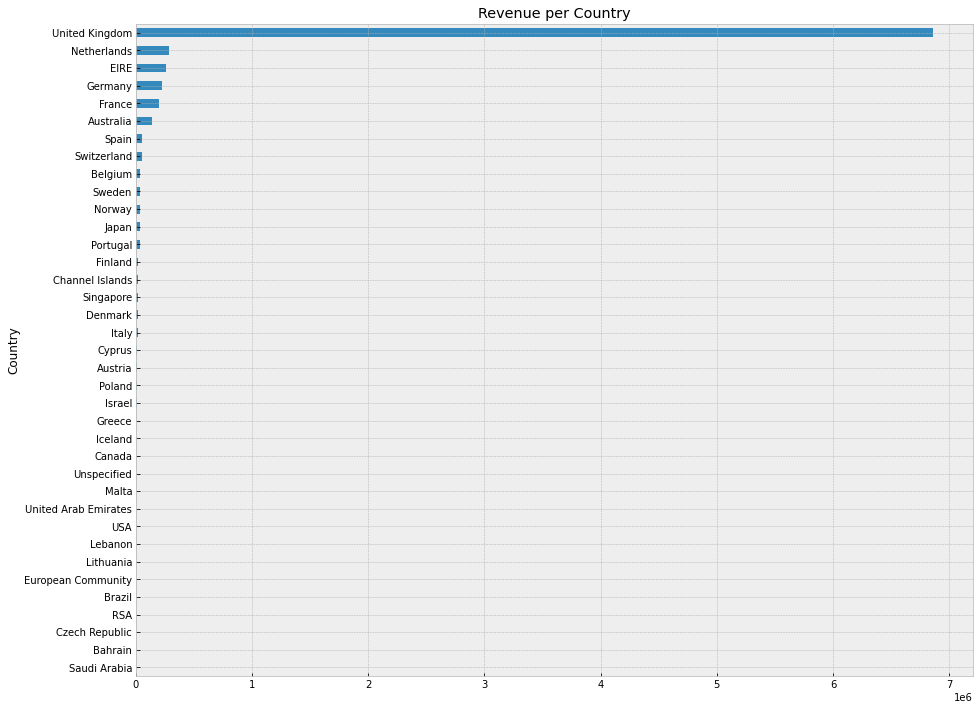

In [ ]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")

Text(0.5, 1.0, 'Number of Invoices per Country')

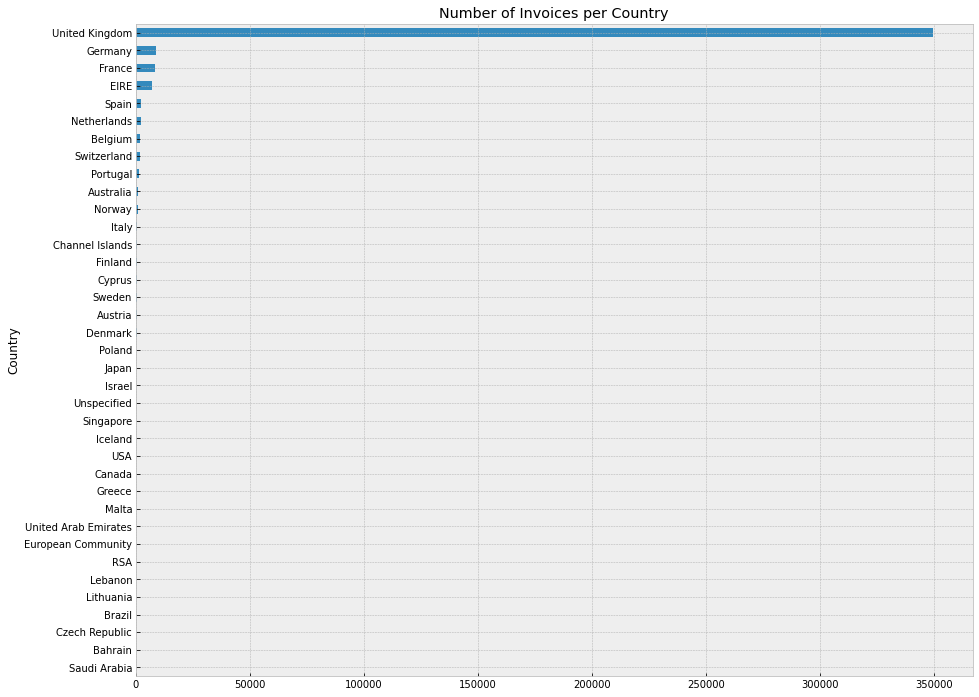

In [ ]:
No_invoice_per_country = df_cleaned.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")

This is very interesting since we can see that Netherlands is the 2nd country in value even though it has less invoices than countries like Germany or France for example and 10 times less customers. (95, 87 and 9 for Germany, France and Netherlands respectively)

In [ ]:
le = LabelEncoder()
le.fit(df_cleaned['Country'])

LabelEncoder()

In [ ]:
l = [i for i in range(37)]
dict(zip(list(le.classes_), l))

{'Australia': 0,
 'Austria': 1,
 'Bahrain': 2,
 'Belgium': 3,
 'Brazil': 4,
 'Canada': 5,
 'Channel Islands': 6,
 'Cyprus': 7,
 'Czech Republic': 8,
 'Denmark': 9,
 'EIRE': 10,
 'European Community': 11,
 'Finland': 12,
 'France': 13,
 'Germany': 14,
 'Greece': 15,
 'Iceland': 16,
 'Israel': 17,
 'Italy': 18,
 'Japan': 19,
 'Lebanon': 20,
 'Lithuania': 21,
 'Malta': 22,
 'Netherlands': 23,
 'Norway': 24,
 'Poland': 25,
 'Portugal': 26,
 'RSA': 27,
 'Saudi Arabia': 28,
 'Singapore': 29,
 'Spain': 30,
 'Sweden': 31,
 'Switzerland': 32,
 'USA': 33,
 'United Arab Emirates': 34,
 'United Kingdom': 35,
 'Unspecified': 36}

In [ ]:
df_cleaned['Country'] = le.transform(df_cleaned['Country'])


In [ ]:
with open('labelencoder.pickle', 'wb') as g:
    pickle.dump(le, g)

In [ ]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,35,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,35,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,35,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,35,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,35,0,20.34


**RFM**

In [ ]:
df_cleaned['InvoiceDate'].min()

'1/10/2011 10:32'

In [ ]:
df_cleaned['InvoiceDate'].max()

'9/9/2011 9:52'

In [ ]:
NOW = dt.datetime(2011,12,10)
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [ ]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"


rfmTable = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [ ]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [ ]:
rfmTable.head(5)

,InvoiceDate,CustomerID,TotalPrice,Recency
InvoiceNo,,,,
536365,2010-12-01 08:26:00,17850,139.12,373.0
536366,2010-12-01 08:28:00,17850,22.20,373.0
536367,2010-12-01 08:34:00,13047,278.73,373.0
536368,2010-12-01 08:34:00,13047,70.05,373.0
536369,2010-12-01 08:35:00,13047,17.85,373.0


In [ ]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [ ]:
rfmTable_final.head(5)

,min_recency,max_recency,frequency,monetary_value
CustomerID,,,,
12346,325.0,325.0,1,0.00
12347,2.0,367.0,7,4310.00
12348,75.0,358.0,4,1797.24
12349,18.0,18.0,1,1757.55
12350,310.0,310.0,1,334.40


In [ ]:
first_customer = df_cleaned[df_cleaned['CustomerID']=='12747']
first_customer.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,35,0,30.60
9755,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747,35,0,15.30
9756,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747,35,0,27.04
9757,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747,35,0,39.60
9758,537215,85064,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747,35,0,32.70


The first customer has shopped a lot !

In [ ]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
segmented_rfm = rfmTable_final

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

Here we'll apply a score on each feature of RFM

In [ ]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4
12347,2.0,367.0,7,4310.00,1,1,1
12348,75.0,358.0,4,1797.24,3,2,1
12349,18.0,18.0,1,1757.55,2,4,1
12350,310.0,310.0,1,334.40,4,4,3


Finally we'll set a score for each customer in the database.

In [ ]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1797.24,3,2,1,321
12349,18.0,18.0,1,1757.55,2,4,1,241
12350,310.0,310.0,1,334.40,4,4,3,443


In [ ]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
14646,1.0,354.0,75,279558.62,1,1,1,111
18102,0.0,367.0,60,259657.30,1,1,1,111
17450,8.0,367.0,47,193332.83,1,1,1,111
14911,1.0,373.0,202,138074.54,1,1,1,111
14156,9.0,371.0,55,114378.45,1,1,1,111
...,...,...,...,...,...,...,...,...
16115,9.0,292.0,8,1660.88,1,1,1,111
16813,8.0,204.0,10,1652.18,1,1,1,111
15953,15.0,369.0,8,1651.33,1,1,1,111


In [ ]:
segmented_rfm.head(5)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1797.24,3,2,1,321
12349,18.0,18.0,1,1757.55,2,4,1,241
12350,310.0,310.0,1,334.40,4,4,3,443


In [ ]:
segmented_rfm = segmented_rfm.reset_index()

In [ ]:
segmented_rfm.head(5)

,CustomerID,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346,325.0,325.0,1,0.00,4,4,4,444
1,12347,2.0,367.0,7,4310.00,1,1,1,111
2,12348,75.0,358.0,4,1797.24,3,2,1,321
3,12349,18.0,18.0,1,1757.55,2,4,1,241
4,12350,310.0,310.0,1,334.40,4,4,3,443


In [ ]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='CustomerID')


In [ ]:
df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCanceled', 'TotalPrice',
       'min_recency', 'max_recency', 'frequency', 'monetary_value',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFMScore'],
      dtype='object')

We don't need the quartiles anymore, let's drop them.

In [ ]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

In [ ]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)

In [ ]:
df_cleaned['Month'].value_counts()

11    63194
10    48799
12    42708
9     39678
5     28082
6     26933
3     26877
8     26810
7     26587
4     22438
1     20992
2     19711
Name: Month, dtype: int64

In [ ]:
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)


In [ ]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,35,0,15.30,372.0,373.0,34,5322.84,411,12,2,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,35,0,22.00,372.0,373.0,34,5322.84,411,12,2,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8


**Product Categories**

In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
X = df_cleaned["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3878, 1698) of float64


In [ ]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3878, 100) of float64


In [ ]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

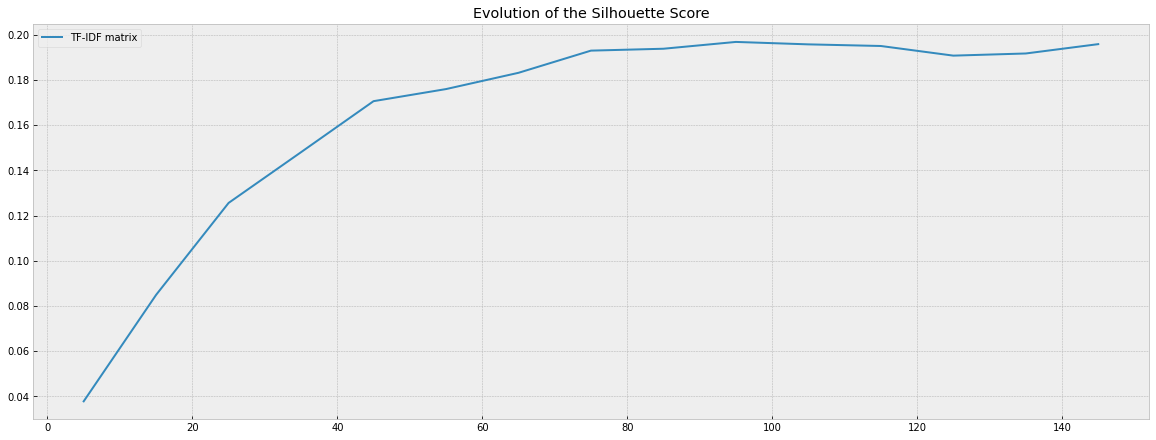

In [ ]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()


The highest value for the silhouette score is when there are 135 clusters. So we'll chose this value.

Text(0.5, 1.0, 'ACP with 135 clusters')

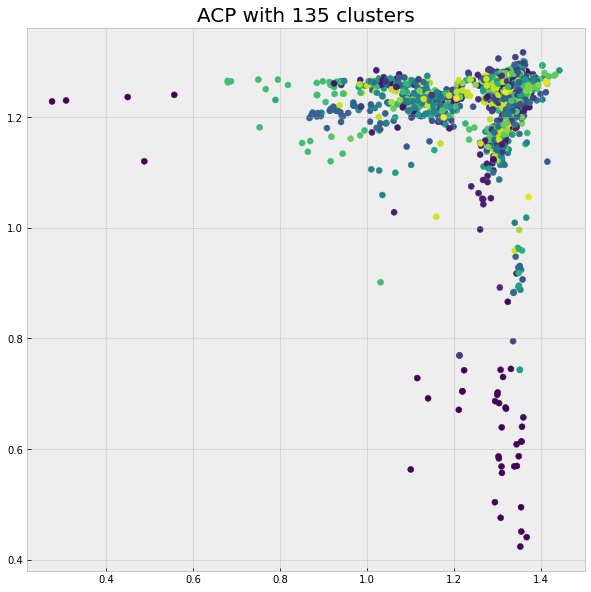

In [ ]:
n_clusters = 135

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 135 clusters", fontsize="20")

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

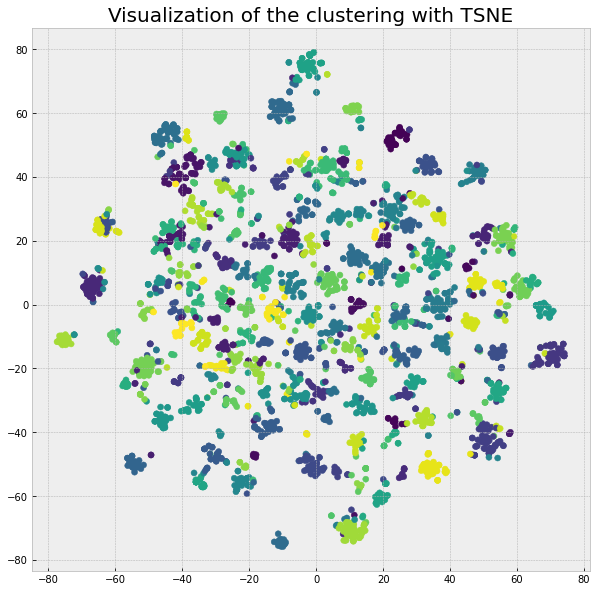

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")


<Figure size 432x288 with 0 Axes>

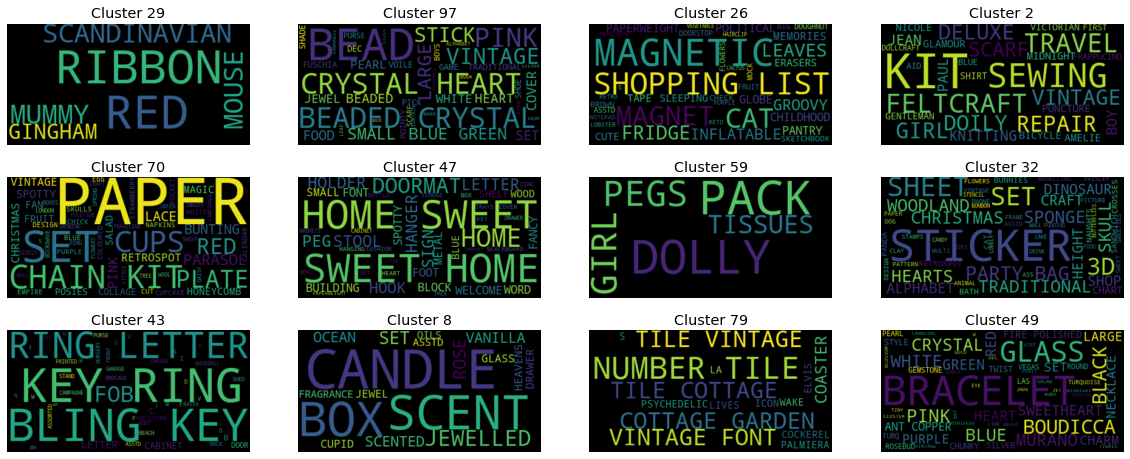

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

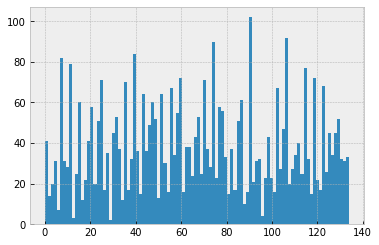

In [ ]:
pd.Series(clusters).hist(bins=100)

In [ ]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

In [ ]:
with open('product_clusters.pickle', 'wb') as h:
    pickle.dump(dict_article_to_cluster, h)

**CREATING CUSTOMER CATEGORIES**

In [ ]:
cluster = df_cleaned['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["TotalPrice"], 0)
df2 = pd.concat([df_cleaned['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [ ]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


df_grouped = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [ ]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)


In [ ]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
df_grouped_final.head(5)

TotalPrice                   min_recency max_recency frequency  \
                  min    max       mean    <lambda>    <lambda>  <lambda>   
CustomerID                                                                  
12346             0.0    0.0   0.000000       325.0       325.0         1   
12347            13.2   45.0  23.308571         2.0       367.0         7   
12348            39.6  150.0  82.840000        75.0       358.0         4   
12349            15.0   15.0  15.000000        18.0        18.0         1   
12350            25.2   25.2  25.200000       310.0       310.0         1   

           monetary_value Quantity  Country  
                 <lambda>      sum <lambda>  
CustomerID                                   
12346                0.00    74215       35  
12347             4310.00     2458       16  
12348             1797.24     2341       12  
12349             1757.55      631       18  
12350              334.40      197       24

In [ ]:
df_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequency", "monetary_value", "quantity", "country"]

In [ ]:
df_grouped_final.head(5)

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country
CustomerID,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16
12348,39.6,150.0,82.840000,75.0,358.0,4,1797.24,2341,12
12349,15.0,15.0,15.000000,18.0,18.0,1,1757.55,631,18
12350,25.2,25.2,25.200000,310.0,310.0,1,334.40,197,24


In [ ]:
df2_grouped_final.head(5)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
12347,0.000000,0.003884,0.006376,0.000000,0.0,0.000000,0.0,0.0,0.0,0.009049,...,0.018759,0.106218,0.0,0.003132,0.018376,0.006961,0.0,0.0,0.0,0.0
12348,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.221807,0.200307,0.0,0.0,0.0,0.0
12349,0.022731,0.041137,0.021251,0.010071,0.0,0.009388,0.0,0.0,0.0,0.019800,...,0.041473,0.000000,0.0,0.000000,0.000000,0.170692,0.0,0.0,0.0,0.0
12350,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.119617,0.0,0.0,0.0,0.0


**Customer Clustering**

In [ ]:
X1 = df_grouped_final
X2 = df2_grouped_final

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)


In [ ]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.85799976670062 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.4978995633554486 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.25489029730952856 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.3264501892949548 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.39120736739396106 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.4019444011023534 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.40364054474885475 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.4100963336743558 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.40092401622138163 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.4014739861455747 with Std Scaling


We want to have at least 5, 6 clusters so we won't take 2 or 3 clusters even though they have the highest silhouette scores, 8 clusters would fit the best here.

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

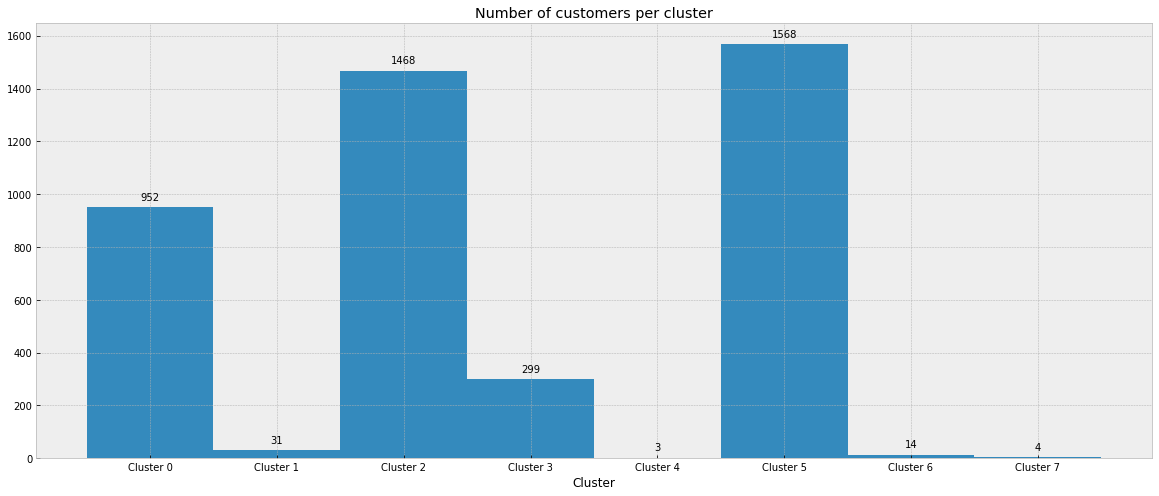

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [ ]:
df_grouped_final["cluster"] = clusters

In [ ]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()


,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35,1,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16,3,...,0.018759,0.106218,0.0,0.003132,0.018376,0.006961,0.0,0.0,0.0,0.0
12348,39.6,150.0,82.840000,75.0,358.0,4,1797.24,2341,12,3,...,0.000000,0.000000,0.0,0.000000,0.221807,0.200307,0.0,0.0,0.0,0.0
12349,15.0,15.0,15.000000,18.0,18.0,1,1757.55,631,18,3,...,0.041473,0.000000,0.0,0.000000,0.000000,0.170692,0.0,0.0,0.0,0.0
12350,25.2,25.2,25.200000,310.0,310.0,1,334.40,197,24,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.119617,0.0,0.0,0.0,0.0


In [ ]:
final_dataset_V2 = final_dataset.reset_index()

In [ ]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

In [ ]:
with open('df_cleaned.pickle', 'wb') as f:
    pickle.dump(df_cleaned, f)

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

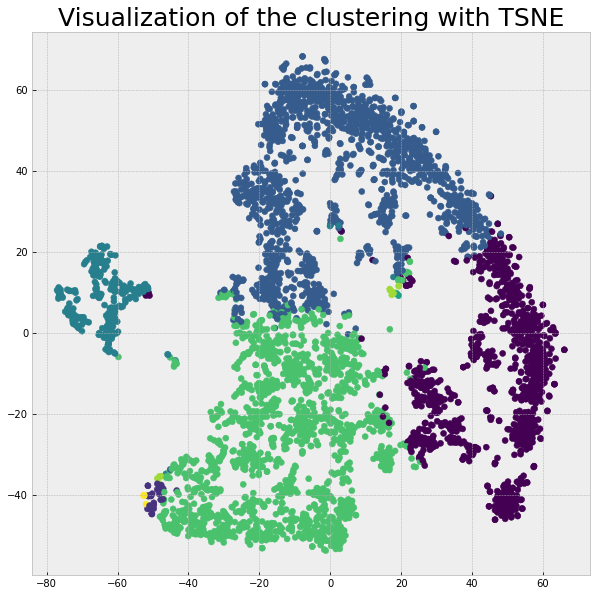

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

Graphically the clusters are distinctive enough. Let's take a closer look at the clusters that contain few customers.

In [ ]:
final_dataset[final_dataset['cluster']==0]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12350,25.20,25.20,25.200,310.0,310.0,1,334.40,197,24,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.119617,0.000000,0.000000,0.0,0.000000
12354,20.80,20.80,20.800,232.0,232.0,1,1079.40,530,30,0,...,0.000000,0.000000,0.0,0.007875,0.000000,0.000000,0.016398,0.000000,0.0,0.000000
12377,19.80,37.20,28.500,315.0,354.0,2,1628.12,944,32,0,...,0.000000,0.055278,0.0,0.000000,0.000000,0.060008,0.000000,0.000000,0.0,0.000000
12410,17.00,17.00,17.000,308.0,308.0,2,693.33,211,32,0,...,0.032452,0.000000,0.0,0.000000,0.000000,0.230770,0.000000,0.000000,0.0,0.024519
12510,33.00,162.72,97.860,142.0,325.0,2,982.57,353,30,0,...,0.015266,0.000000,0.0,0.008651,0.000000,0.170980,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18250,14.85,14.85,14.850,310.0,310.0,1,349.27,199,35,0,...,0.087754,0.000000,0.0,0.000000,0.029204,0.000000,0.000000,0.104504,0.0,0.000000
18260,15.00,39.60,25.095,172.0,358.0,6,2598.40,1475,35,0,...,0.014163,0.000000,0.0,0.004811,0.054403,0.000000,0.010622,0.000000,0.0,0.000000
18269,18.60,18.60,18.600,366.0,366.0,1,168.60,76,35,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [ ]:
final_dataset[final_dataset['cluster']==0].mean()

min             27.602626
max             40.474685
mean            33.589860
min_recency    251.075630
max_recency    282.013655
                  ...    
Cluster_130      0.004053
Cluster_131      0.007552
Cluster_132      0.005304
Cluster_133      0.000000
Cluster_134      0.007308
Length: 145, dtype: float64

In [ ]:
temp_final_df = final_dataset.reset_index()

In [ ]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['CustomerID'])

In [ ]:
cluster0 = df_cleaned[df_cleaned['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity              8.545888
UnitPrice             3.440047
QuantityCanceled      0.125697
TotalPrice           15.566883
frequency             2.666448
min_recency         236.188472
monetary_value      862.101144
dtype: float64

In [ ]:
cluster0['Description'].value_counts()[:10]


WHITE HANGING HEART T-LIGHT HOLDER    230
REGENCY CAKESTAND 3 TIER              185
PARTY BUNTING                         137
ASSORTED COLOUR BIRD ORNAMENT         129
JAM MAKING SET WITH JARS              104
REX CASH+CARRY JUMBO SHOPPER          103
NATURAL SLATE HEART CHALKBOARD        102
SET OF 3 CAKE TINS PANTRY DESIGN      101
HEART OF WICKER SMALL                  98
HEART OF WICKER LARGE                  86
Name: Description, dtype: int64

In [ ]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
cluster0_grouped['RFMScore'].value_counts()

444    395
443    187
433     94
434     56
432     51
422     47
423     35
442     31
424     12
421     10
411      7
431      6
412      6
441      4
333      2
322      2
413      2
321      1
323      1
414      1
332      1
334      1
Name: RFMScore, dtype: int64

In [ ]:
cluster0_grouped['Country'].value_counts()

35    923
26      6
30      5
32      5
18      2
23      2
24      1
28      1
31      1
33      1
20      1
25      1
21      1
36      1
34      1
Name: Country, dtype: int64

In [ ]:
cluster0['Month'].value_counts()


12    5258
3     4314
5     3691
4     3570
2     3342
1     3205
6     3089
7      975
8        3
Name: Month, dtype: int64

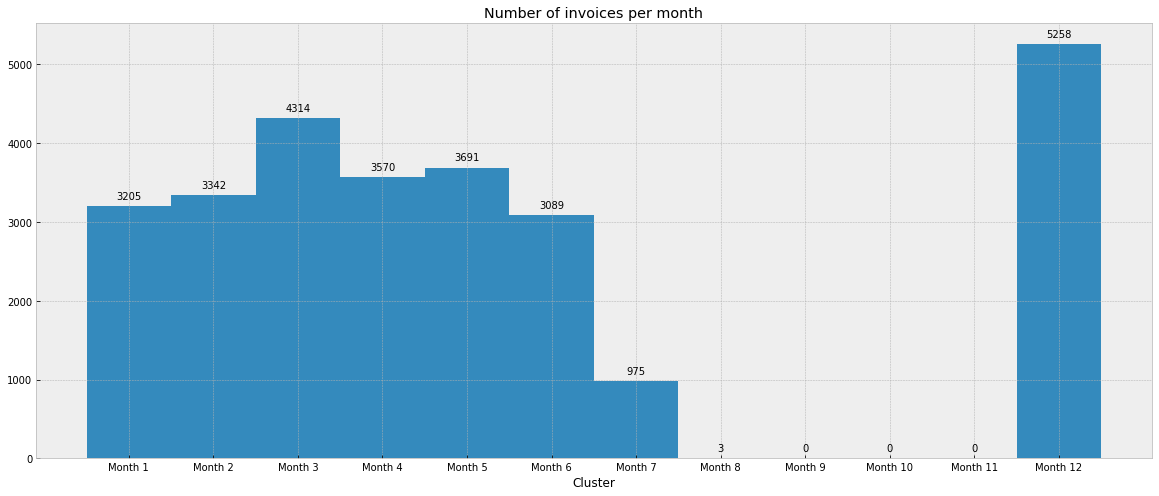

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [ ]:
temp['Year'] = cluster0[cluster0['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

2010.0    702
Name: Year, dtype: int64

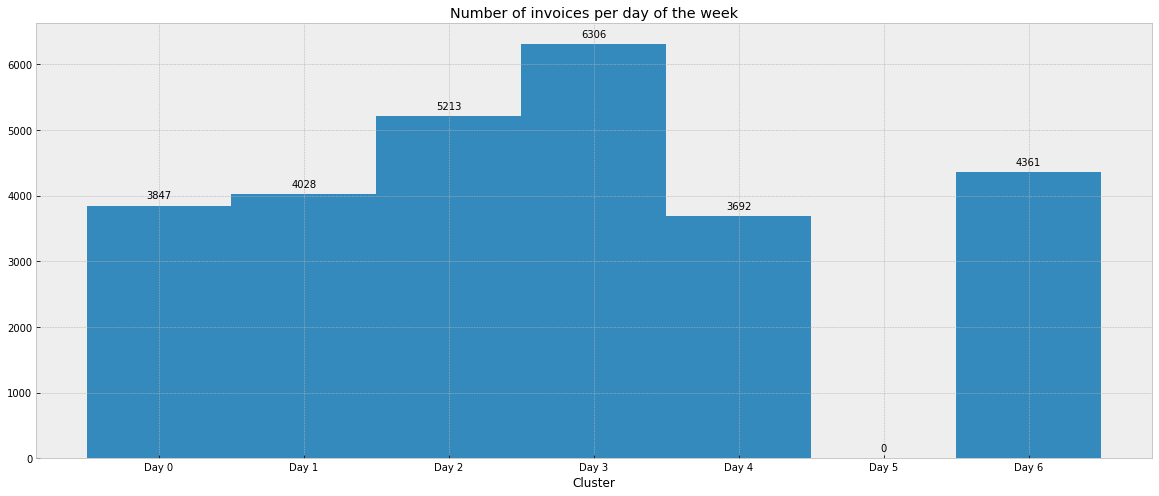

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [ ]:
cluster0['Day'].nunique()


31

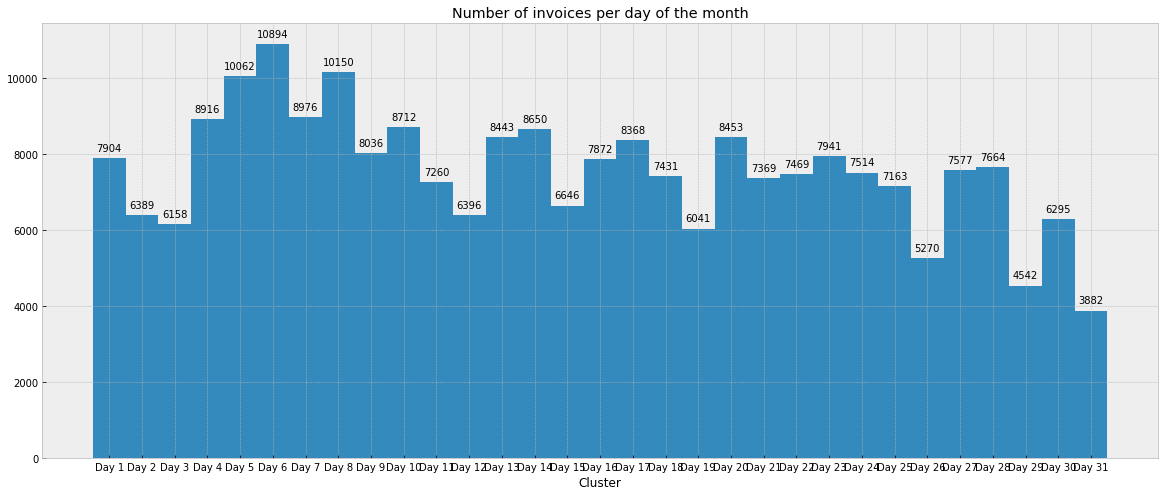

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [ ]:
cluster0['Hour'].nunique()

14

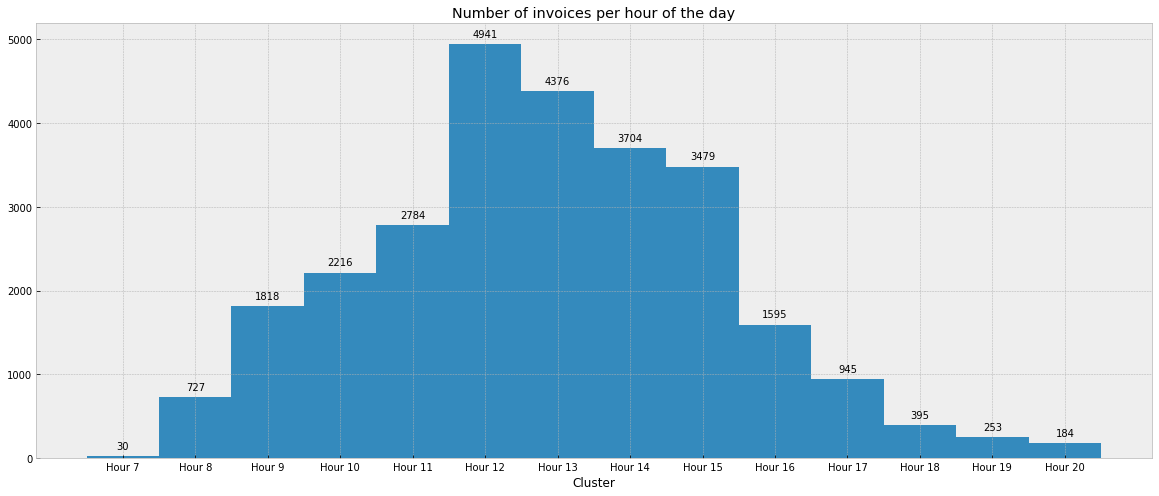

In [ ]:

plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster0['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

**Classification of Customers**

In [ ]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [ ]:
final_dataset.shape

(4339, 145)